In [4]:
from flask import render_template
from jinja2 import Environment
import os
import sys
import cv2
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./test_flask.ipynb'))))
# from face_detection import *

from flask import Flask, flash, redirect, render_template, request, session, abort, Response

import psycopg2

from recognition import *

/usr/local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
app = Flask(__name__)
ans = 'No prediction yet'
flag = 0

def table_ops(conn, schema, table):
    cur = conn.cursor()
    cur.execute("select * from %s.%s ;" % (schema, table))
    rows = cur.fetchall()
    conn.close()
    print("---done---")
    return rows

def connect_db():
    try:
        conn = psycopg2.connect("dbname='postgres' user='akshayt' host='ec2-54-212-196-78.us-west-2.compute.amazonaws.com' port='5432' password='Theia628'")
    except:
        print("I am unable to connect to the database")
    
    print("--connected---")
    return conn


@app.route('/user_home', methods=['POST'])
def do_admin_login():
    conn = connect_db()
    table = table_ops(conn, 'msan', 'user')
    for row in table:
        if request.form['password'] == row[4] and request.form['username'] == row[3]:
            session['logged_in'] = True
        else:
            flash('wrong password!')
    """
    if request.form['password'] == 'password' and request.form['username'] == 'admin':
        session['logged_in'] = True
    else:
        flash('wrong password!')
    POST_USERNAME = str(request.form['username'])
    POST_PASSWORD = str(request.form['password'])
 
    Session = sessionmaker(bind=engine)
    s = Session()
    query = s.query(User).filter(User.username.in_([POST_USERNAME]), User.password.in_([POST_PASSWORD]) )
    result = query.first()
    if result:
        session['logged_in'] = True
    else:
        flash('wrong password!')
    """
    return main()


@app.route("/logout")
def logout():
    session['logged_in'] = False
    return main()


@app.route("/")
def main():
    if not session.get('logged_in'): #added the following lines
        return render_template('login_page.html')
    else:
        return main2()


@app.route("/user_home")
def main2():
    #need a logout button

    conn = connect_db()
    table = table_ops(conn, 'msan', 'class')
    class_names = [row[2] for row in table]

    if (session['logged_in'] == True):
        return render_template('user_home.html', class_names = class_names)
    else:
        return page_not_found()

@app.route("/404.html")
def page_not_found():
    return render_template('404.html')

@app.route("/take_attendance/<name>")
def display_data(name):
    conn = connect_db()
    table = table_ops(conn, 'msan', 'attendance')
    return render_template('take_attendance.html', table=table, class_name = name)



@app.route("/check_attendance/<name>")
def hi(name):
    conn = connect_db()
    table = table_ops(conn, 'msan', 'attendance')

    sid = [row[0] for row in table]
    cid = [row[1] for row in table]
    date = [row[2] for row in table]
    length = len(sid)

    return render_template('check_attendance.html', table=table, class_name = name, sid = sid, cid = cid, date=date, length=length)

In [6]:
@app.route('/servercamera.htm')
def servercamera():
    return render_template('servercamera.html')


def prediction(frame):
    if(len(frame)>0):
        # cv2.imwrite("./data/tmp/face.jpg", frame)
        pred = who_is_it(frame)
        return pred

def gen_pred():
    while True:
        yield render_template('prediction.html', prediction=ans)

def gen(camera):
    global flag
    global ans
    while True:
        frame = camera.get_frame()
        _,jpeg = cv2.imencode('.jpg', frame)

        print (ans)
        ans = prediction(frame)
        if flag == 0:
            break
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + jpeg.tobytes() + b'\r\n\r\n')

@app.route('/video_feed')
def video_feed():
    return Response(gen(VideoCamera()),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/pred_res')
def pred_res():
    print ("--------here in pred_res--------")
    return Response(gen_pred(), mimetype='text/html')

@app.route('/break_gen')
def break_gen():
    global flag
    flag = 0

In [16]:
if __name__ == "__main__":
    app.secret_key = os.urandom(12)
    app.run(host='0.0.0.0', port=8081, debug=True)

OSError: [Errno 48] Address already in use

In [15]:
! kill $(lsof -t -i:8081)

SystemExit: 0

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

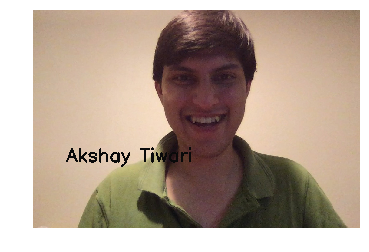

In [49]:
# Create a black image
img = np.zeros((512,512,3), np.uint8)

# Write some Text
x= 10
y = 10

frame = cv2.imread('./data/Photo on 2-3-18 at 12.07 AM.jpg')

font                   = cv2.AGAST_FEATURE_DETECTOR_THRESHOLD
bottomLeftCornerOfText = (x + 100,400+100)
fontScale              = 2
fontColor              = (10,10,10)
lineType               = 5

cv2.putText(frame,'Akshay Tiwari', 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

#Display the image
plt_show(frame)

In [59]:
cascPath = "./haarcascade_frontalface_default.xml"


def cut_faces(image, faces_coord):
    (x, y, w, h) = faces_coord
    return image[y:h, x : x + (w-x)]

def crop_face(image):
    # imagePath = image_path

    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cascPath)

    # Read the image
    # image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    face_cut = gray

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # print("Found {0} faces!".format(len(faces)))

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        box = np.array([x, y, x + w, y + h])
        face_cut = cut_faces(image, box.astype("int"))
        # plt_show(face_cut)
        break
    return face_cut, faces


In [60]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

In [94]:
temp = []
count = 0
names = []
for filename in os.listdir('./data/crops/'):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        name = os.path.splitext(filename)[0]
        face = cv2.imread('./data/crops/'+filename)
        temp.append(face)
        names.append(filename)        

In [98]:
face_aug = seq.augment_images(temp)
for i in range(len(face_aug)):
    ia.seed(5)
    face = face_aug[i]
    filename = names[i]
    cv2.imwrite("./data/augs/"+ str(6) + '-' +filename, face)

In [89]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

# images_aug = seq.augment_images(images)

In [107]:
os.path.exists('./face.jpg')

False